### Lab | Making predictions with logistic regression

In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

Instructions

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.
2. Read the data into a Pandas dataframe.
3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.
4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.
5. Create a logistic regression model to predict this variable from the cleaned data.
6. Evaluate the results.

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
import numpy as np

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

In [7]:
#address sakila database 
engine.execute("USE sakila")
engine.execute("SET sql_mode=(SELECT REPLACE(@@sql_mode, 'ONLY_FULL_GROUP_BY', ''))")

### 1. Creating DataFrame 

#### 1.1. film_id, release year, rental rate, length, rating, category, amount of copies

In [34]:
query = """ select f.film_id, f.release_year, f.rental_rate, f.length, f.rating, 
c.name as category, count(i.inventory_id) as quant_invent from film as f
join film_category as fc on fc.film_id = f.film_id
join category as c on c.category_id = fc.category_id
join inventory as i on i.film_id = f.film_id
group by f.film_id
order by f.film_id"""

data_1 = pd.read_sql_query(query, engine)
data_1

,film_id,release_year,rental_rate,length,rating,category,quant_invent
0,1,2006,0.99,86,PG,Documentary,8
1,2,2006,4.99,48,G,Horror,3
2,3,2006,2.99,50,NC-17,Documentary,4
3,4,2006,2.99,117,G,Horror,7
4,5,2006,2.99,130,G,Family,3
...,...,...,...,...,...,...,...
953,996,2006,0.99,183,G,Documentary,2
954,997,2006,0.99,179,NC-17,Music,2
955,998,2006,0.99,105,NC-17,Horror,2
956,999,2006,2.99,101,R,Children,5


#### 1.2. film_id, how many times film was rented last month (15 may - 30 May)

In [20]:
query = """ select i.film_id, count(r.inventory_id) as times_rented_lm from rental as r 
right outer join inventory as i on 
r.inventory_id = i.inventory_id and r.rental_date >= 20050515 and r.rental_date <= 20050530
group by i.film_id order by i.film_id"""

data_2 = pd.read_sql_query(query, engine)
data_2

,film_id,times_rented_lm
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1
...,...,...
1635,1681,0
1636,1682,0
1637,1683,0
1638,1684,0


#### 1.3. film_id, YES/NO was rented last month (15 may - 30 May)

In [27]:
query = """ with magic_table as 
(select i.film_id, count(r.inventory_id) as times_rented_lm from rental as r 
right outer join inventory as i on 
r.inventory_id = i.inventory_id and r.rental_date >= 20050515 and r.rental_date <= 20050530
group by i.film_id order by i.film_id)

select film_id, if(times_rented_lm > 0, "YES", "NO") as rented_lm from magic_table"""

data_3 = pd.read_sql_query(query, engine)
data_3

,film_id,rented_lm
0,1,YES
1,2,NO
2,3,NO
3,4,YES
4,5,YES
...,...,...
1635,1681,NO
1636,1682,NO
1637,1683,NO
1638,1684,NO


#### 1.4. film_id, YES/NO there's a top 10 actor in it

In [22]:
query = """ select film_id, if( film_id in (

select distinct(film_id) from film_actor 
where actor_id in 
(

select actor_id as p_actor from 
(
    select actor_id, count(film_id) as film_count, row_number() over (order by count(film_id) desc) as magic 
    from film_actor
    group by actor_id
    order by count(film_id) desc
) as alias_1

where magic > 0 and magic <=10
)
) , 'YES', 'NO') as pop_actor from film"""

data_4 = pd.read_sql_query(query, engine)
data_4

,film_id,pop_actor
0,1,YES
1,2,NO
2,3,NO
3,4,YES
4,5,YES
...,...,...
1677,1681,NO
1678,1682,NO
1679,1683,NO
1680,1684,NO


#### 1.5. film_id, YES/NO was rented this month (15 June - 30 June)

In [28]:
query = """ with magic_table as 
(select i.film_id, count(r.inventory_id) as times_rented_lm from rental as r 
right outer join inventory as i on 
r.inventory_id = i.inventory_id and r.rental_date >= 20050615 and r.rental_date <= 20050630
group by i.film_id order by i.film_id)

select film_id, if(times_rented_lm > 0, "YES", "NO") as rented_tm from magic_table"""

data_5 = pd.read_sql_query(query, engine)
data_5

,film_id,rented_tm
0,1,YES
1,2,NO
2,3,YES
3,4,YES
4,5,YES
...,...,...
1635,1681,NO
1636,1682,NO
1637,1683,NO
1638,1684,NO


### 2. Joining DataFrames

In [35]:
#merging to get only films with full information (cutting out 2020 )
data_a = pd.merge(data_1, data_2, on = 'film_id')
data_b = pd.merge(data_a, data_3, on = 'film_id')
data_c = pd.merge(data_b, data_4, on = 'film_id')
data = pd.merge(data_c, data_5, on = 'film_id')
data

,film_id,release_year,rental_rate,length,rating,category,quant_invent,times_rented_lm,rented_lm,pop_actor,rented_tm
0,1,2006,0.99,86,PG,Documentary,8,1,YES,YES,YES
1,2,2006,4.99,48,G,Horror,3,0,NO,NO,NO
2,3,2006,2.99,50,NC-17,Documentary,4,0,NO,NO,YES
3,4,2006,2.99,117,G,Horror,7,1,YES,YES,YES
4,5,2006,2.99,130,G,Family,3,1,YES,YES,YES
...,...,...,...,...,...,...,...,...,...,...,...
953,996,2006,0.99,183,G,Documentary,2,0,NO,NO,YES
954,997,2006,0.99,179,NC-17,Music,2,0,NO,YES,YES
955,998,2006,0.99,105,NC-17,Horror,2,0,NO,YES,YES
956,999,2006,2.99,101,R,Children,5,0,NO,NO,YES


### 3. Data Exloration 

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("whitegrid")

In [37]:
print("The dataframe has {} rows and {} columns".format(data.shape[0],data.shape[1]))
print()
print("The data types of each column of the dataframe are:")
print(data.dtypes)
print()




The dataframe has 958 rows and 11 columns

The data types of each column of the dataframe are:
film_id              int64
release_year         int64
rental_rate        float64
length               int64
rating              object
category            object
quant_invent         int64
times_rented_lm      int64
rented_lm           object
pop_actor           object
rented_tm           object
dtype: object



In [38]:
data.describe()

,film_id,release_year,rental_rate,length,quant_invent,times_rented_lm
count,958.000000,958.0,958.000000,958.000000,958.000000,958.000000
mean,502.598121,2006.0,2.977474,115.490605,4.781837,0.871608
std,287.541738,0.0,1.643152,40.471844,1.816390,0.904654
min,1.000000,2006.0,0.990000,46.000000,2.000000,0.000000
25%,256.250000,2006.0,0.990000,80.250000,3.000000,0.000000
50%,504.500000,2006.0,2.990000,114.000000,5.000000,1.000000
75%,751.750000,2006.0,4.990000,150.000000,6.000000,1.000000
max,1000.000000,2006.0,4.990000,185.000000,8.000000,5.000000


In [40]:
print(data.isna().sum())

film_id            0
release_year       0
rental_rate        0
length             0
rating             0
category           0
quant_invent       0
times_rented_lm    0
rented_lm          0
pop_actor          0
rented_tm          0
dtype: int64


#### 3.1. Categorical data

The categorical columns are:  ['rating', 'category', 'rented_lm', 'pop_actor', 'rented_tm']

Frequency analysis of column:  rating

Frequency analysis of column:  category

Frequency analysis of column:  rented_lm

Frequency analysis of column:  pop_actor

Frequency analysis of column:  rented_tm



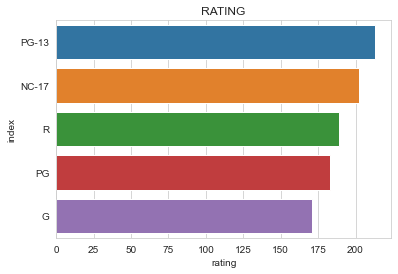

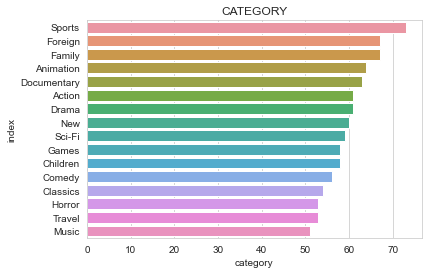

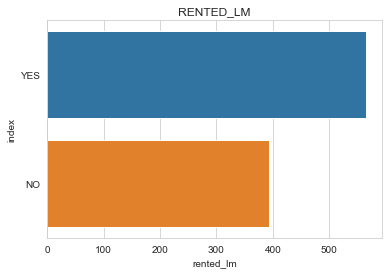

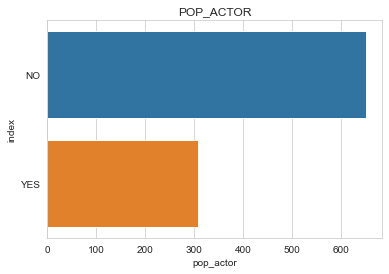

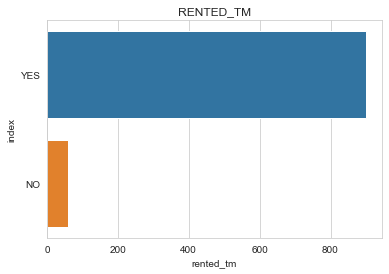

<Figure size 432x288 with 0 Axes>

In [41]:
cols_cat = list(data.select_dtypes(include=['object']).columns)
print("The categorical columns are: ",cols_cat)
print("========================================")
print()

for col in cols_cat:
    print("Frequency analysis of column: ",col)
    my_data = data[col].value_counts().reset_index()
    ax = sns.barplot(x=col, y="index", data = my_data).set_title(col.upper())
    plt.figure()
    print()

#### 3.2. Numerical Data

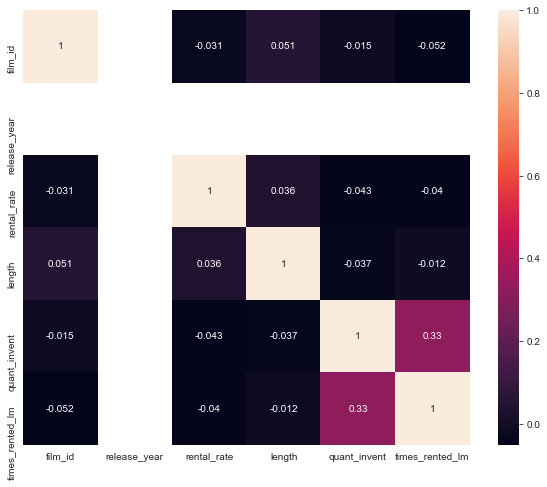

In [42]:
#numerical data correlations
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

Dropping:
1. Film_id - as unique
2. Release year - as the same 

In [44]:
data_copy = data.copy()

data = data.drop(['film_id', 'release_year'], axis = 1)
data

,rental_rate,length,rating,category,quant_invent,times_rented_lm,rented_lm,pop_actor,rented_tm
0,0.99,86,PG,Documentary,8,1,YES,YES,YES
1,4.99,48,G,Horror,3,0,NO,NO,NO
2,2.99,50,NC-17,Documentary,4,0,NO,NO,YES
3,2.99,117,G,Horror,7,1,YES,YES,YES
4,2.99,130,G,Family,3,1,YES,YES,YES
...,...,...,...,...,...,...,...,...,...
953,0.99,183,G,Documentary,2,0,NO,NO,YES
954,0.99,179,NC-17,Music,2,0,NO,YES,YES
955,0.99,105,NC-17,Horror,2,0,NO,YES,YES
956,2.99,101,R,Children,5,0,NO,NO,YES


The numeric columns are:  ['rental_rate', 'length', 'quant_invent', 'times_rented_lm']



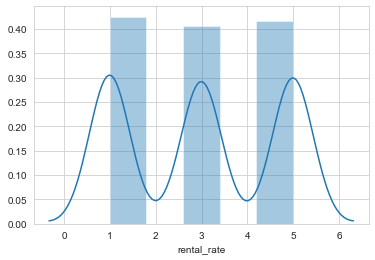

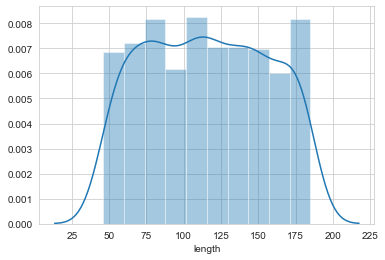

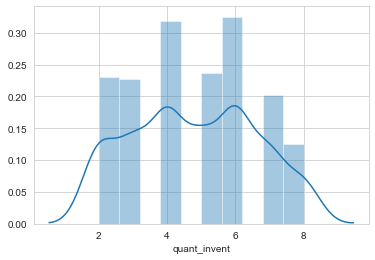

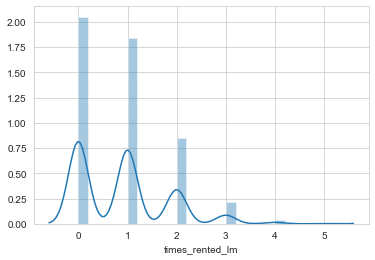

In [51]:
cols_num = list(data.select_dtypes(include=['number']).columns)
print("The numeric columns are: ",cols_num)
print("========================================")
print()

for col in cols_num:
    sns.distplot(data[col])
    plt.show()
   

#### 3.3. Dummies

In [52]:
data = pd.get_dummies(data, drop_first = True)
data

,rental_rate,length,quant_invent,times_rented_lm,rating_NC-17,rating_PG,rating_PG-13,rating_R,category_Animation,category_Children,...,category_Games,category_Horror,category_Music,category_New,category_Sci-Fi,category_Sports,category_Travel,rented_lm_YES,pop_actor_YES,rented_tm_YES
0,0.99,86,8,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
1,4.99,48,3,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2.99,50,4,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2.99,117,7,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1
4,2.99,130,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,0.99,183,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
954,0.99,179,2,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
955,0.99,105,2,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
956,2.99,101,5,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1


### 4. Logistic Regression Model 

#### 4.1 Raw Data

In [53]:
y = data['rented_tm_YES']
X = data.drop(['rented_tm_YES'], axis = 1)

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19698)

In [61]:
#training the model for logistic regression 
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, max_iter = 1000, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

In [62]:
from sklearn.metrics import accuracy_score
predictions = classification.predict(X_test)

The accuracy of the model on test set is: 0.91 


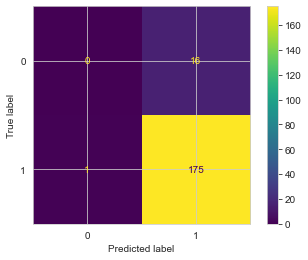

In [63]:
#check how many matches between prediction and actual results 

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP


In [64]:
from sklearn.metrics import cohen_kappa_score
print (cohen_kappa_score(y_test, predictions))

-0.00990099009900991


In [65]:
y.value_counts()
#Very unbalanced data 

1    900
0     58
Name: rented_tm_YES, dtype: int64

#### 4.2 Normalised data 

In [67]:
from sklearn.preprocessing import StandardScaler

transformer = StandardScaler().fit(X)
x_standarized = transformer.transform(X)
x_standarized = pd.DataFrame(x_standarized)
X = x_standarized

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19698)

In [69]:
classification = LogisticRegression(random_state=0, max_iter = 1000, solver='lbfgs',
                  multi_class='ovr').fit(X_train, y_train)

In [70]:
predictions = classification.predict(X_test)

The accuracy of the model on test set is: 0.92 


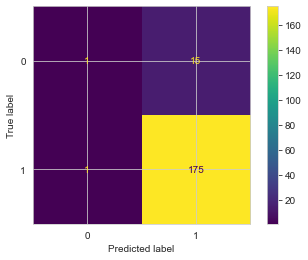

In [71]:
#check how many matches between prediction and actual results 

print("The accuracy of the model on test set is: %4.2f " % accuracy_score(y_test, predictions))
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)  # doctest: +SKIP
plt.show()  # doctest: +SKIP



In [72]:
print (cohen_kappa_score(y_test, predictions))

0.09433962264150952


It became a liiiitle bit better, but still really bad because of unbalance